In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [6]:
!pip install xgboost lightgbm

In [7]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/shared data/train.csv')
features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/shared data/features.csv')
stores = pd.read_csv('/content/drive/My Drive/Colab Notebooks/shared data/stores.csv')
customers_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/shared data/customer_train.csv')

Mounted at /content/drive


In [8]:
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

In [9]:
train_merged = train.merge(features, on=['Store','Date','IsHoliday'], how='left')

In [10]:
train_merged = train_merged.merge(stores, on='Store', how='left')

In [11]:
print(f"🔹train_merged Length: {len(train_merged)}")
print(f"🔹customer_train Length: {len(customers_train)}")
min_len = min(len(train_merged), len(customers_train))

train_trimmed = train_merged.iloc[:min_len].reset_index(drop=True)
customers_trimmed = customers_train.iloc[:min_len].reset_index(drop=True)

train_full = pd.concat([train_trimmed, customers_trimmed], axis=1)

🔹train_merged Length: 421570
🔹customer_train Length: 421570


In [12]:
print(train_full.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  Num_Customers  Avg_Spend_per_Customer  \
0         8.106    A 

In [13]:
print(train_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Store                   421570 non-null  int64         
 1   Dept                    421570 non-null  int64         
 2   Date                    421570 non-null  datetime64[ns]
 3   Weekly_Sales            421570 non-null  float64       
 4   IsHoliday               421570 non-null  bool          
 5   Temperature             421570 non-null  float64       
 6   Fuel_Price              421570 non-null  float64       
 7   MarkDown1               150681 non-null  float64       
 8   MarkDown2               111248 non-null  float64       
 9   MarkDown3               137091 non-null  float64       
 10  MarkDown4               134967 non-null  float64       
 11  MarkDown5               151432 non-null  float64       
 12  CPI                     421570

In [14]:
print(train_full.describe())

               Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   
75%        33.000000      74.000000            2012-02-24 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.785297      30.492054                            NaN   

        Weekly_Sales    Temperature     Fuel_Price      MarkDown1  \
count  421570.000000  421570.000000  421570.000000  150681.000000   
mean    15981.258123      60.090059       3.361027    7246.420196   
min     -4988.940000      -2.060000       2.472000       0.270000   
25%      2079.650000      46.680000       2.933000    2240.270000   
50%      7612.030000    

In [15]:
print(train_full.isnull().sum())

Store                          0
Dept                           0
Date                           0
Weekly_Sales                   0
IsHoliday                      0
Temperature                    0
Fuel_Price                     0
MarkDown1                 270889
MarkDown2                 310322
MarkDown3                 284479
MarkDown4                 286603
MarkDown5                 270138
CPI                            0
Unemployment                   0
Type                           0
Size                           0
Num_Customers                  0
Avg_Spend_per_Customer         0
Loyalty_Avg                    0
dtype: int64


In [16]:
print(train_full.duplicated().sum())

0


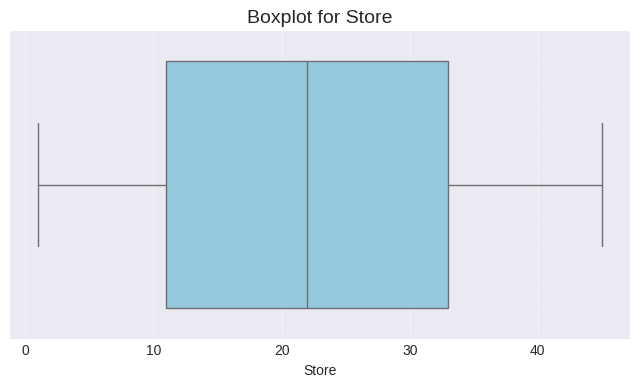

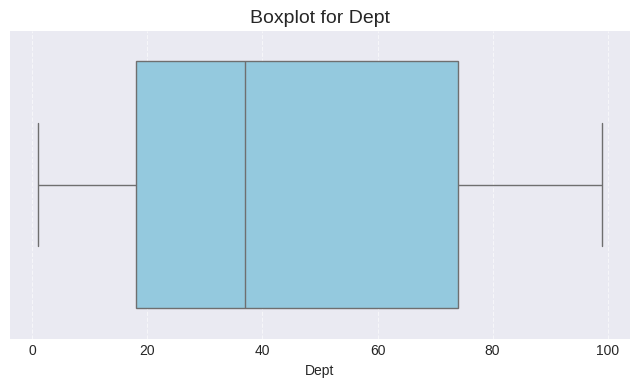

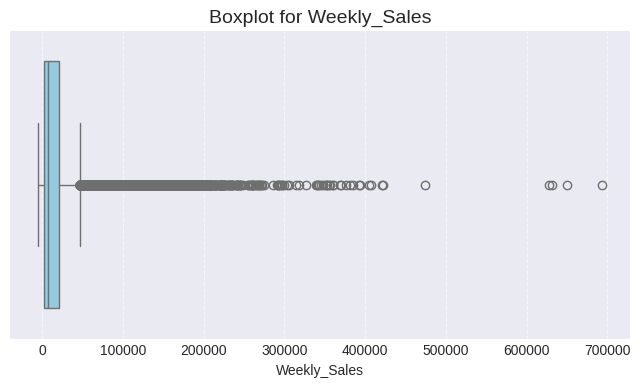

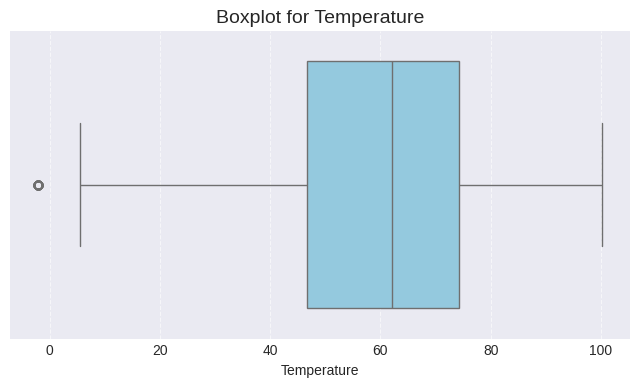

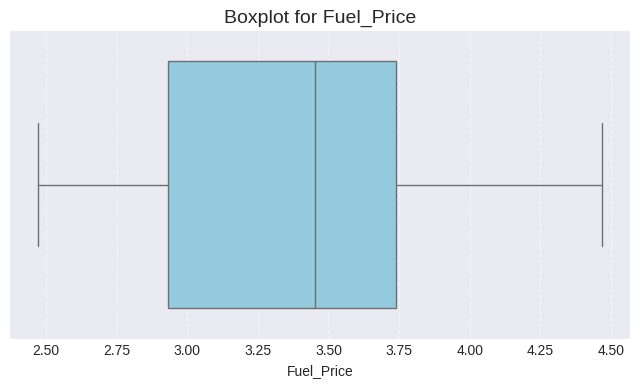

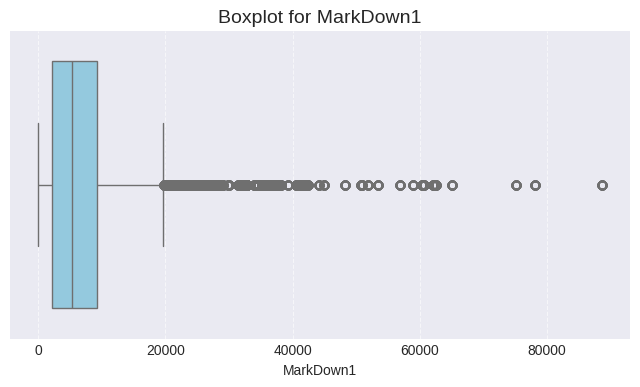

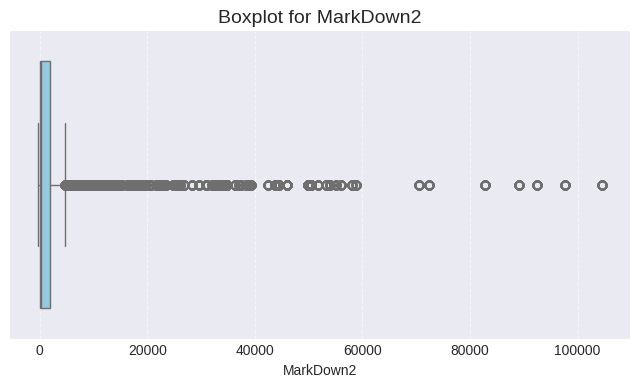

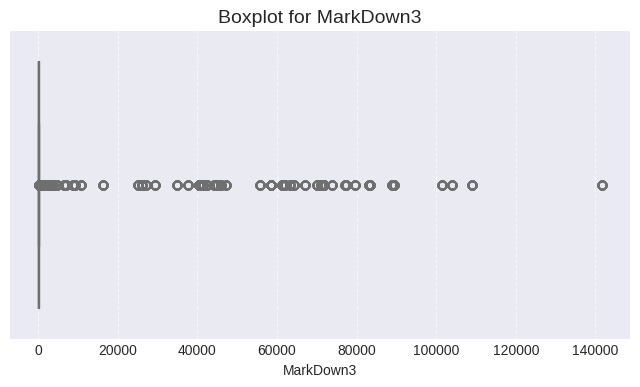

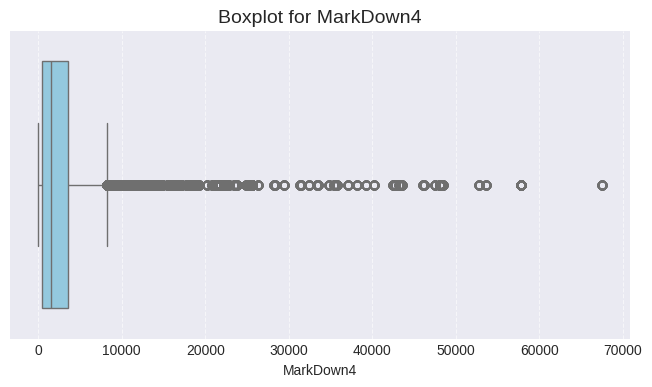

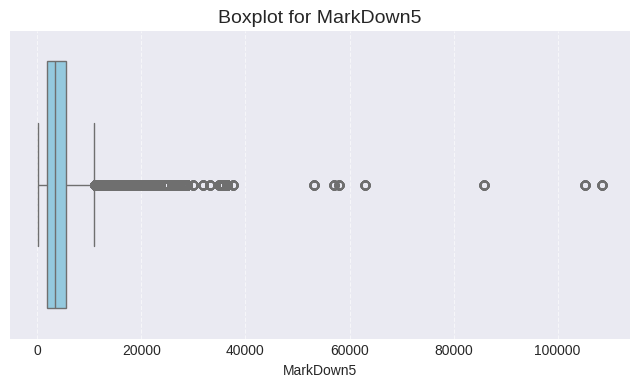

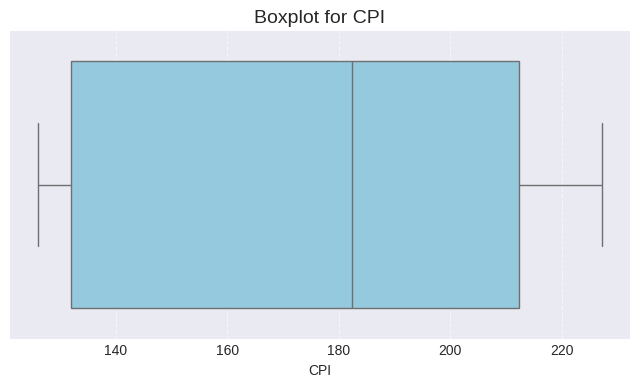

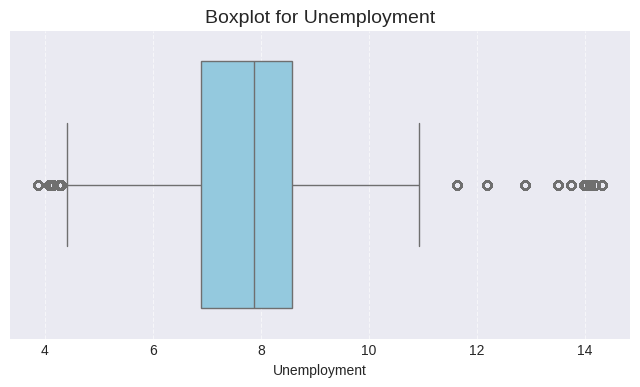

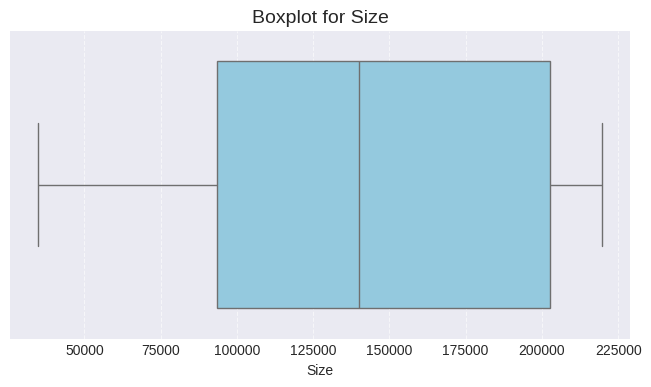

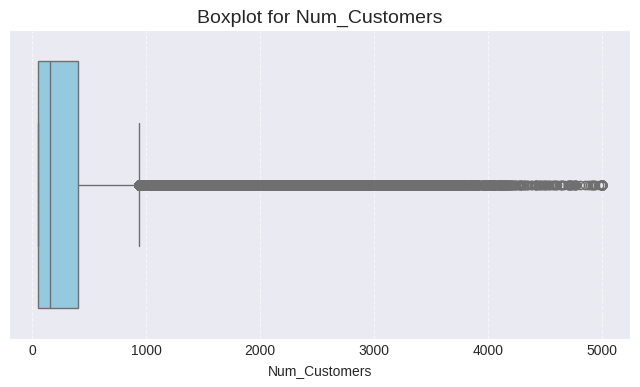

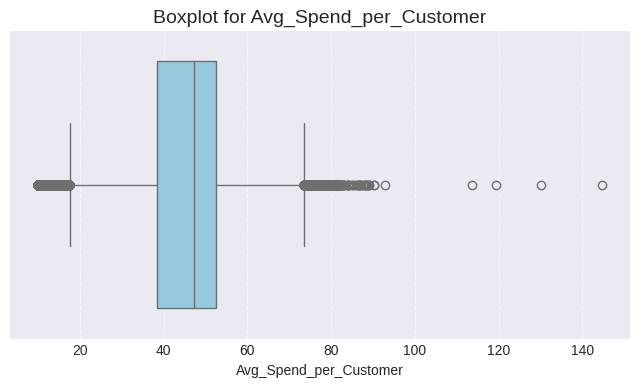

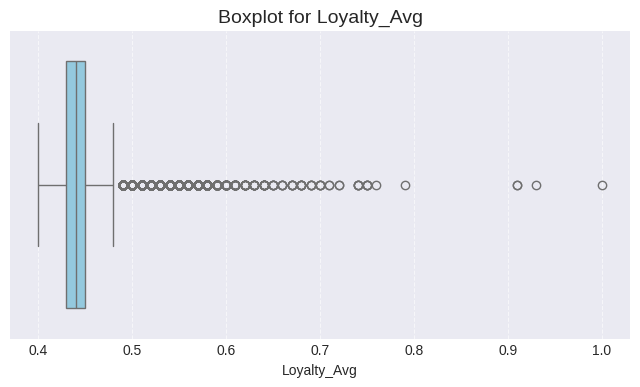

In [17]:
numeric_cols = train_full.select_dtypes(include=['float64', 'int64']).columns

plt.style.use('seaborn-v0_8-darkgrid')

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_full[col], color='skyblue')
    plt.title(f'Boxplot for {col}', fontsize=14)
    plt.xlabel(col)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


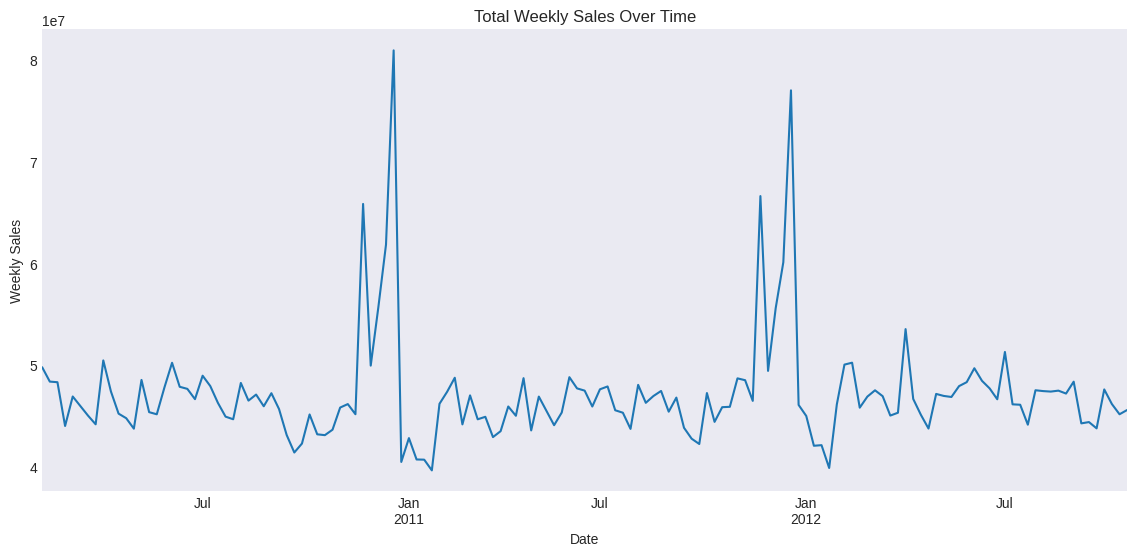

In [18]:
sales_by_date = train_full.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(14,6))
sales_by_date.plot()
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid()
plt.show()

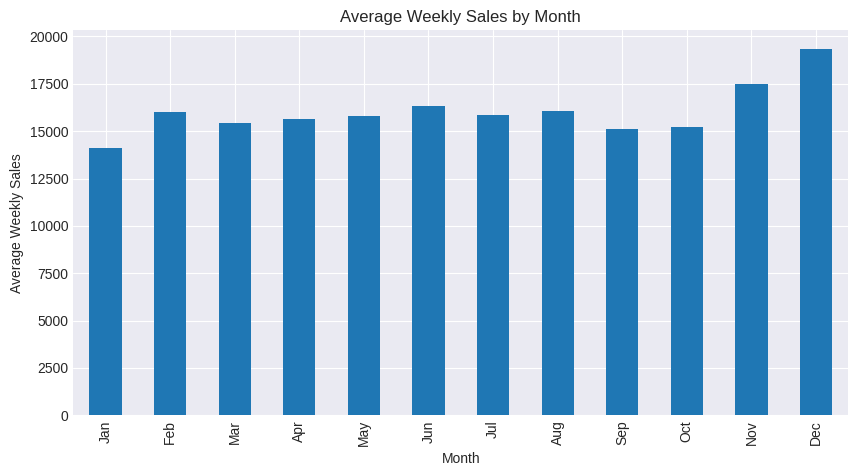

In [19]:
train_full['Month'] = train_full['Date'].dt.strftime('%b %Y')
train_full['Date'].dt.strftime('%b')
monthly_sales = train_full.groupby(train_full['Date'].dt.strftime('%b'))['Weekly_Sales'].mean()

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales = monthly_sales.reindex(month_order)

plt.figure(figsize=(10,5))
monthly_sales.plot(kind='bar')
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.show()

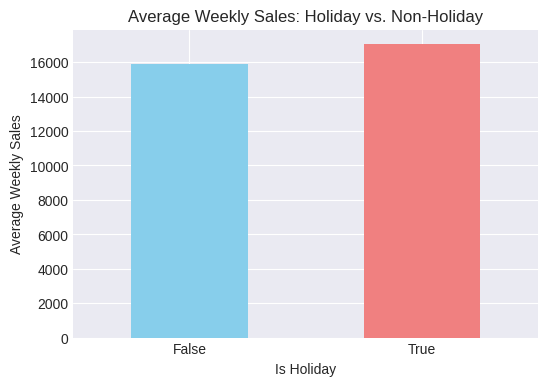

In [20]:
holiday_sales = train_full.groupby('IsHoliday')['Weekly_Sales'].mean()

plt.figure(figsize=(6,4))
holiday_sales.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Weekly Sales: Holiday vs. Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)
plt.show()

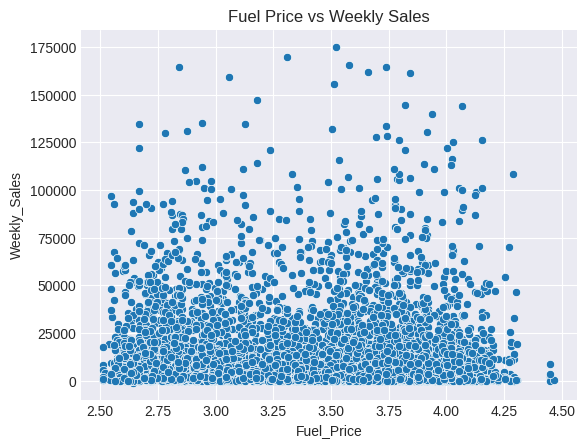

In [21]:
sns.scatterplot(data=train_full.sample(5000), x='Fuel_Price', y='Weekly_Sales')
plt.title('Fuel Price vs Weekly Sales')
plt.show()

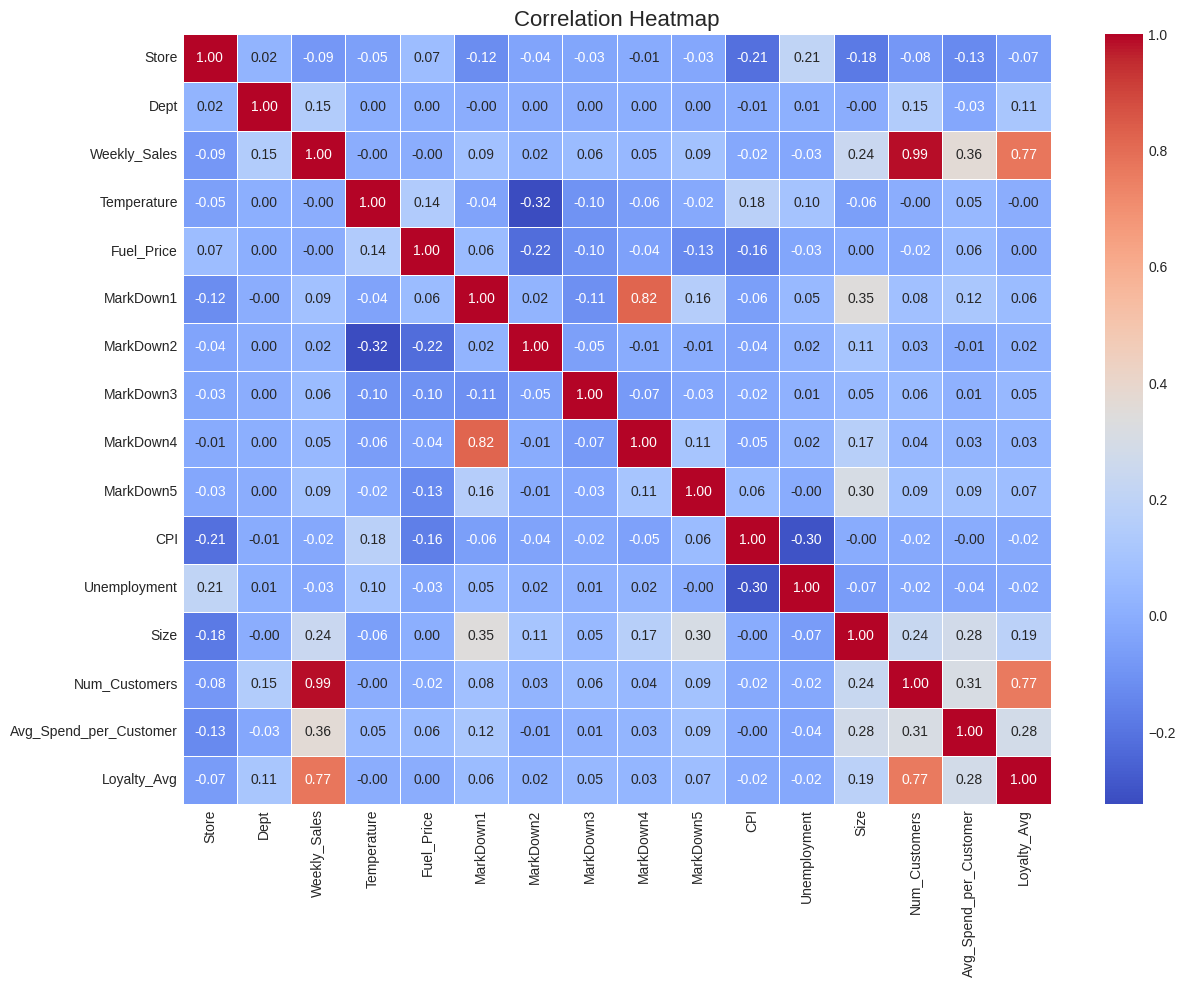

In [22]:
numeric_data = train_full.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [23]:
!pip install dash==2.16.1 jupyter-dash==0.4.2 --quiet --ignore-installed

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==6.17.1, but you have ipykernel 7.1.0 which is incompatible.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 9.7.0 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires tornado==6.5.1, but you have tornado 6.5.2 which is incompatible.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.3 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2.0, but you have jupyter-client 8.6.3 which is incompatible.


In [24]:
# @title
import pandas as pd
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.express as px



columns = [col for col in train_full.columns if col not in ['Weekly_Sales']]

app = JupyterDash(__name__)

app.layout = html.Div(
    style={'backgroundColor': '#0f172a', 'color': '#f8fafc', 'fontFamily': 'Arial, sans-serif', 'padding': '20px'},
    children=[
        html.H1("📊 Weekly Sales Insights Dashboard",
                style={'textAlign': 'center', 'color': '#38bdf8', 'marginBottom': '40px'}),

        html.Div([
            html.Label("Select a feature to compare with Weekly_Sales:",
                       style={'fontSize': '20px', 'color': '#f1f5f9', 'marginBottom': '10px'}),
            dcc.Dropdown(
                id='feature-dropdown',
                options=[{'label': col, 'value': col} for col in columns],
                value='Temperature',
                style={'width': '70%', 'margin': 'auto', 'color': '#0f172a'}
            )
        ], style={'textAlign': 'center', 'marginBottom': '40px'}),

        html.Div([
            dcc.Graph(id='sales-graph', style={'width': '60%', 'display': 'inline-block'}),
            dcc.Graph(id='hist-graph', style={'width': '38%', 'display': 'inline-block'})
        ], style={'textAlign': 'center'})
    ]
)

@app.callback(
    [Output('sales-graph', 'figure'),
     Output('hist-graph', 'figure')],
    Input('feature-dropdown', 'value')
)
def update_graphs(selected_feature):
    if train_full[selected_feature].dtype in ['float64', 'int64']:
        fig1 = px.scatter(train_full, x=selected_feature, y='Weekly_Sales',
                          title=f'Relationship between {selected_feature} and Weekly_Sales',
                          trendline="ols", opacity=0.7, color_discrete_sequence=['#38bdf8'])
    else:
        fig1 = px.box(train_full, x=selected_feature, y='Weekly_Sales',
                      title=f'Relationship between {selected_feature} and Weekly_Sales',
                      color_discrete_sequence=['#10b981'])

    fig1.update_layout(template="plotly_dark", title_font=dict(size=20, color='#f1f5f9'),
                       paper_bgcolor='#0f172a', plot_bgcolor='#0f172a')

    fig2 = px.histogram(train_full, x='Weekly_Sales', nbins=50,
                        title="Weekly_Sales Distribution", color_discrete_sequence=['#f43f5e'])
    fig2.update_layout(template="plotly_dark", title_font=dict(size=20, color='#f1f5f9'),
                       paper_bgcolor='#0f172a', plot_bgcolor='#0f172a')

    return fig1, fig2

app.run_server(mode='inline', port=8051)


/usr/local/lib/python3.12/dist-packages/dash/dash.py:550: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2351888050.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



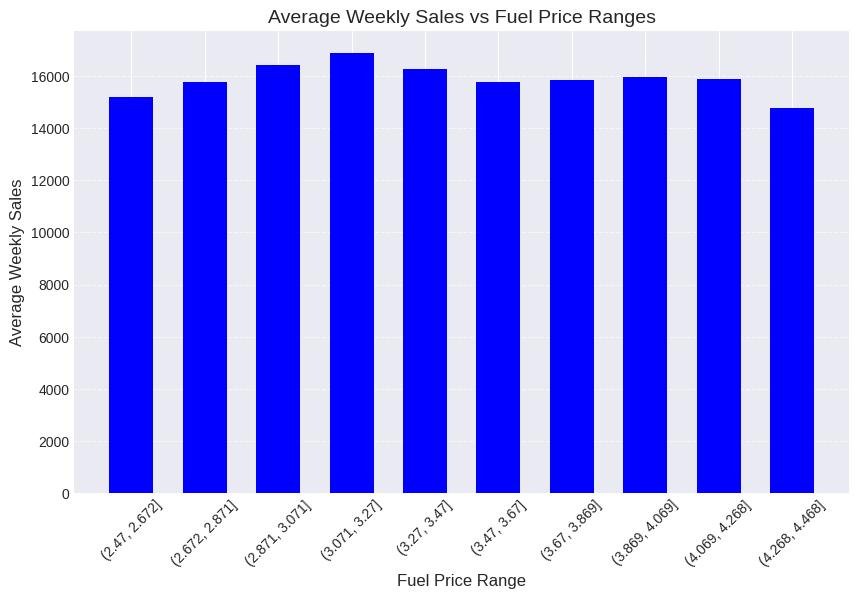

In [25]:
train_full['Fuel_Category'] = pd.cut(train_full['Fuel_Price'], bins=10)


fuel_sales = train_full.groupby('Fuel_Category')['Weekly_Sales'].mean()

plt.figure(figsize=(10,6))
plt.bar(fuel_sales.index.astype(str), fuel_sales.values, color='blue', width=0.6)
plt.title('Average Weekly Sales vs Fuel Price Ranges', fontsize=14)
plt.xlabel('Fuel Price Range', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

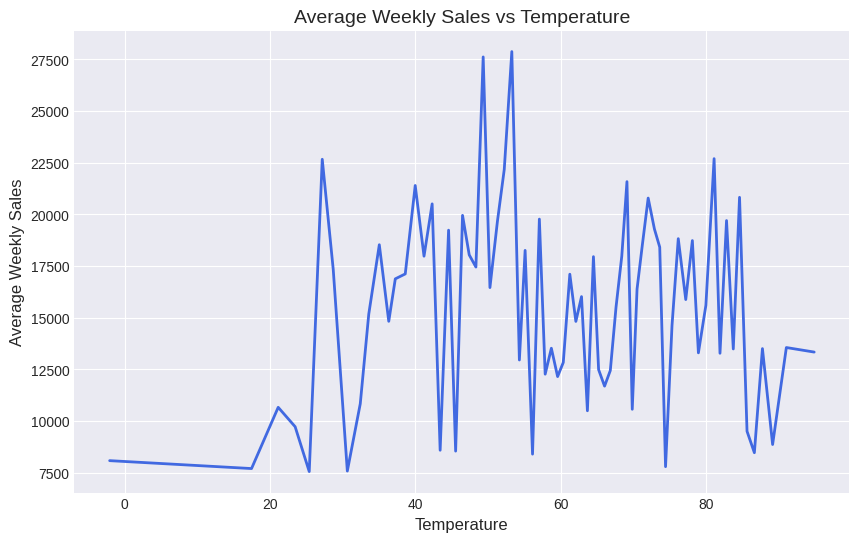

In [26]:
temp_sales = train_full.groupby('Temperature')['Weekly_Sales'].mean().sort_index()

temp_sales_sampled = temp_sales[::50]

plt.figure(figsize=(10,6))
plt.plot(temp_sales_sampled.index, temp_sales_sampled.values, color='royalblue', linewidth=2)
plt.title('Average Weekly Sales vs Temperature',fontsize=14)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.show()

<Axes: title={'center': 'Top 10 Departments by Total Sales'}, xlabel='Dept'>

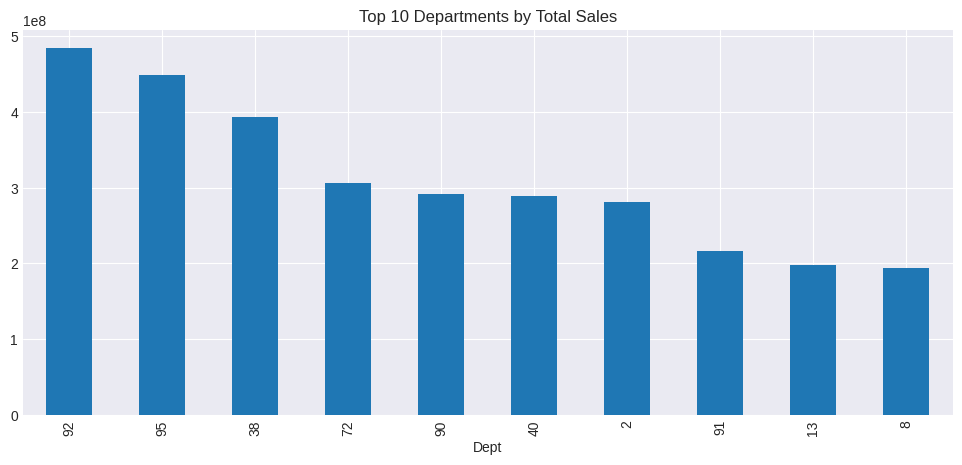

In [27]:
top_depts = train_full.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
top_depts.plot(kind='bar', figsize=(12,5), title='Top 10 Departments by Total Sales')

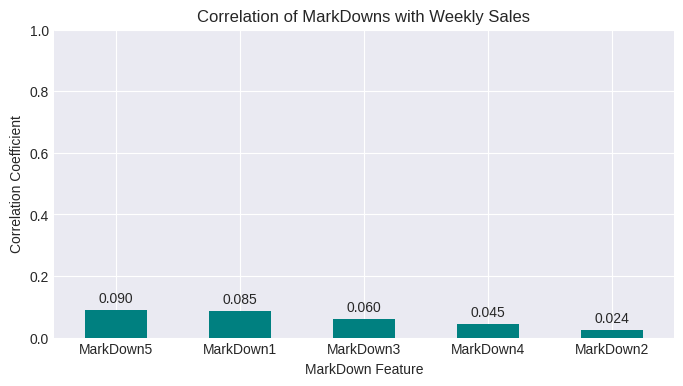

In [28]:
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
corrs = train_full[markdown_cols + ['Weekly_Sales']].corr()['Weekly_Sales'].sort_values(ascending=False)

plt.figure(figsize=(8,4))
bars = corrs.drop('Weekly_Sales').plot(kind='bar', color='teal')
plt.title('Correlation of MarkDowns with Weekly Sales')
plt.xlabel('MarkDown Feature')
plt.ylabel('Correlation Coefficient')
plt.ylim(0, 1)
plt.xticks(rotation=0)

for i, v in enumerate(corrs.drop('Weekly_Sales')):
    plt.text(i, v + 0.025, f"{v:.3f}", ha='center', fontsize=10)

plt.show()

In [29]:
train_full['HasPromotion'] = train_full[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].sum(axis=1) > 0

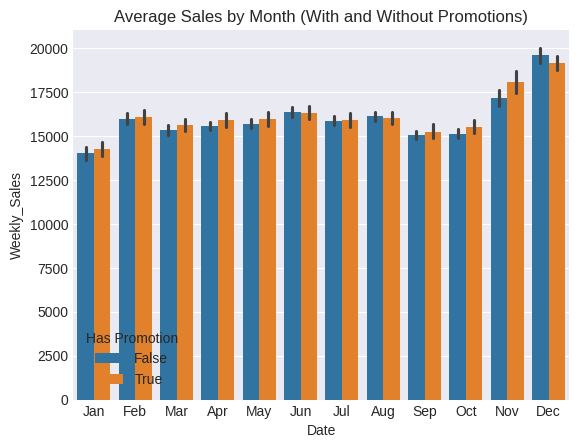

In [30]:
sns.barplot(data=train_full, x=train_full['Date'].dt.strftime('%b'), y='Weekly_Sales', hue='HasPromotion', order=month_order)
plt.title('Average Sales by Month (With and Without Promotions)')
plt.legend(title='Has Promotion', loc='lower left')
plt.show()

In [31]:
train_full = train_full.drop_duplicates()

train_full[markdown_cols] = train_full[markdown_cols].fillna(0)

cols = [
    'Weekly_Sales', 'Temperature', 'MarkDown1', 'MarkDown2', 'MarkDown3',
    'MarkDown4', 'MarkDown5', 'Unemployment',
    'Num_Customers', 'Avg_Spend_per_Customer', 'Loyalty_Avg'
]


for col in cols:
    q1 = train_full[col].quantile(0.25)
    q3 = train_full[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr

    before_outliers = ((train_full[col] < lower) | (train_full[col] > upper)).sum()
    train_full[col] = train_full[col].clip(lower, upper)
    #after_outliers = ((train_full[col] < lower) | (train_full[col] > upper)).sum()

    print(f"🔹 {col}: {before_outliers} outliers were clipped to within bounds")

🔹 Weekly_Sales: 35521 outliers were clipped to within bounds
🔹 Temperature: 69 outliers were clipped to within bounds
🔹 MarkDown1: 55789 outliers were clipped to within bounds
🔹 MarkDown2: 103148 outliers were clipped to within bounds
🔹 MarkDown3: 84674 outliers were clipped to within bounds
🔹 MarkDown4: 79134 outliers were clipped to within bounds
🔹 MarkDown5: 40458 outliers were clipped to within bounds
🔹 Unemployment: 32114 outliers were clipped to within bounds
🔹 Num_Customers: 36494 outliers were clipped to within bounds
🔹 Avg_Spend_per_Customer: 69644 outliers were clipped to within bounds
🔹 Loyalty_Avg: 18225 outliers were clipped to within bounds


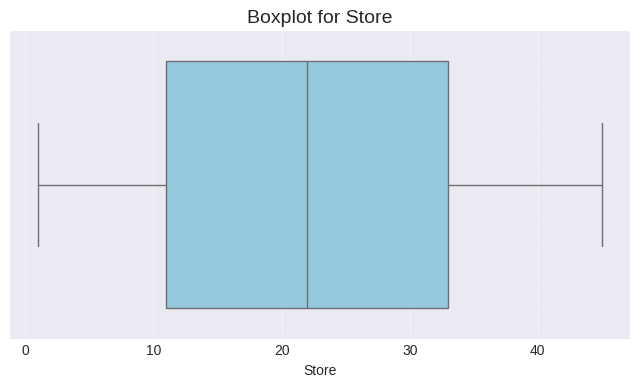

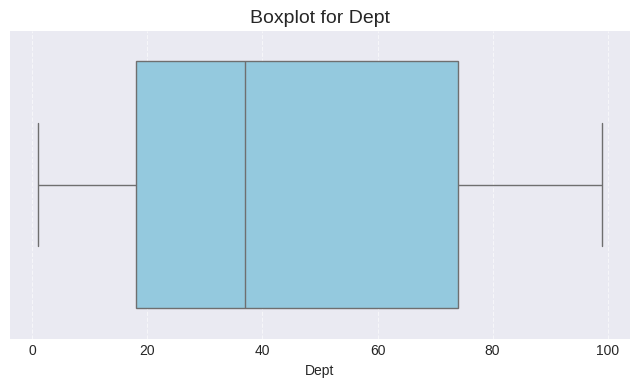

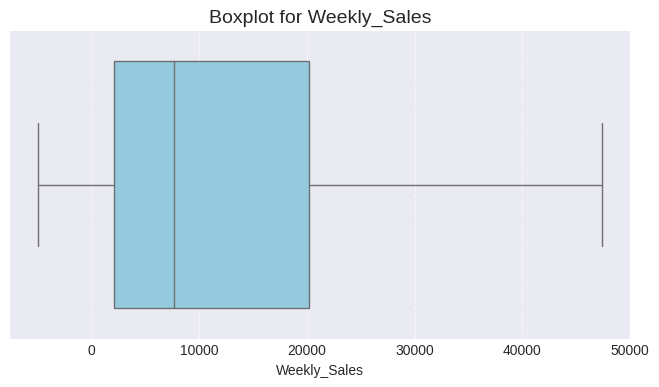

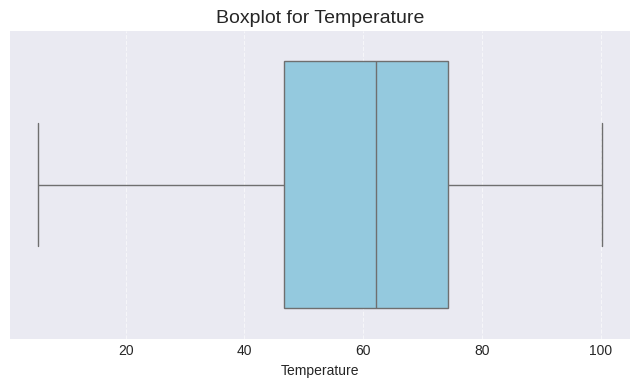

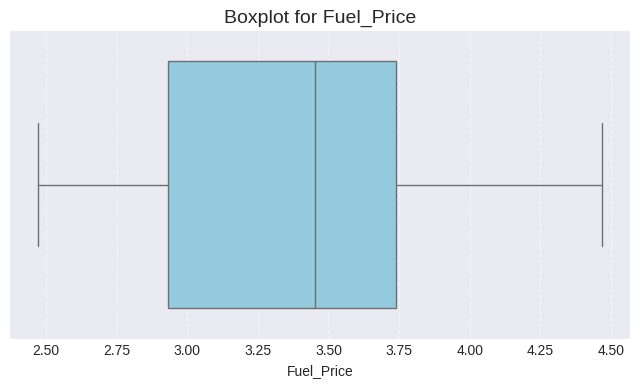

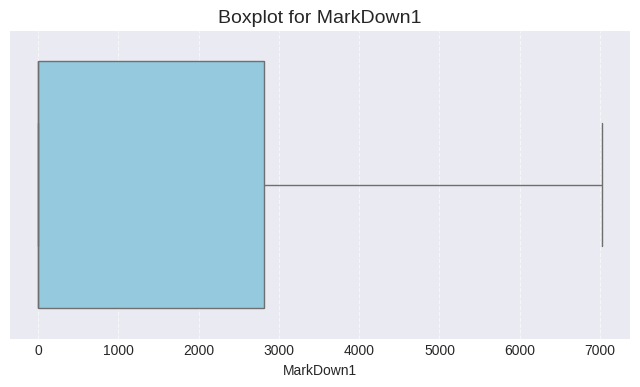

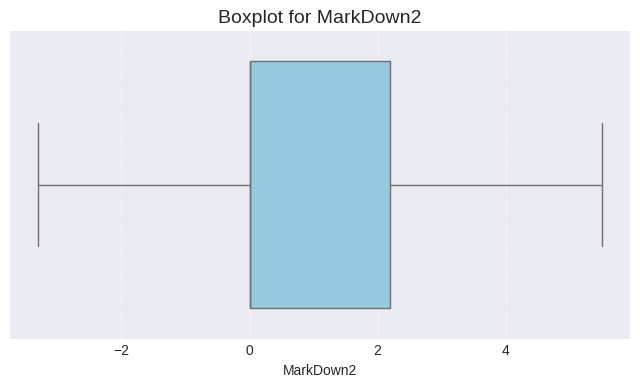

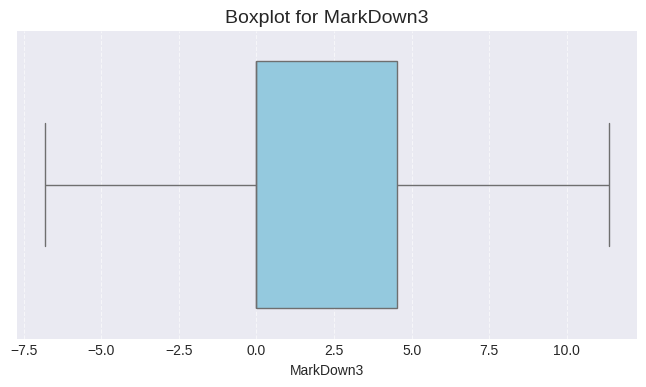

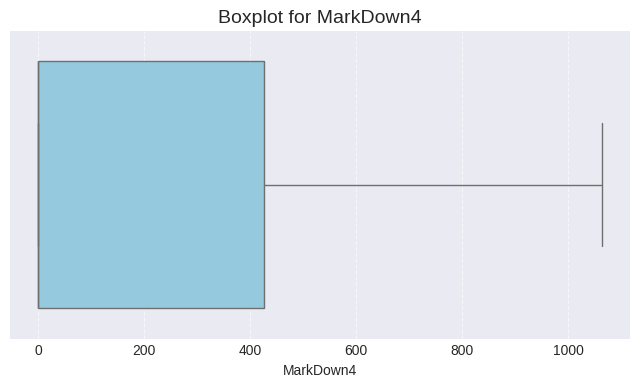

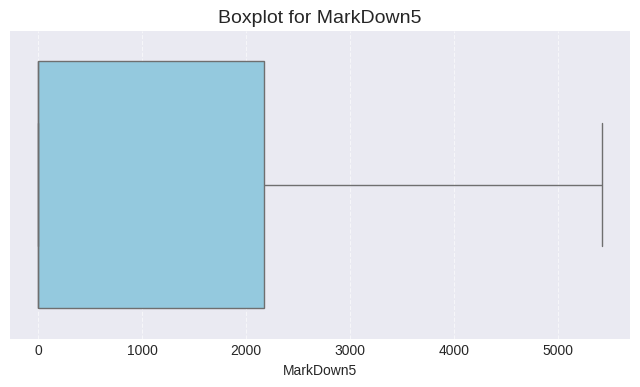

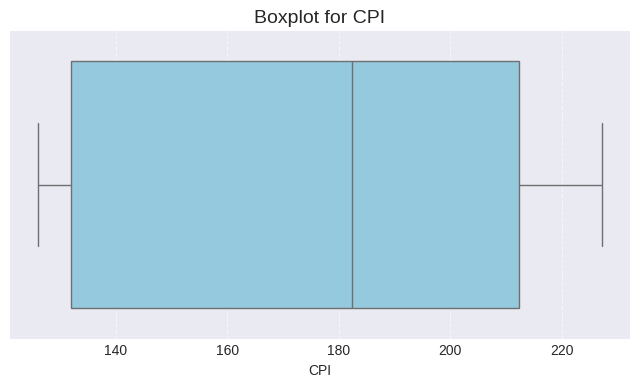

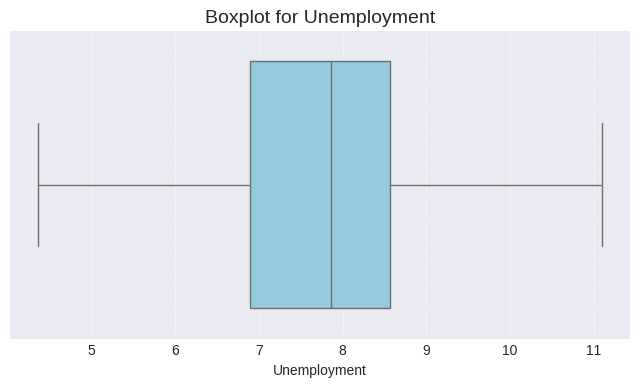

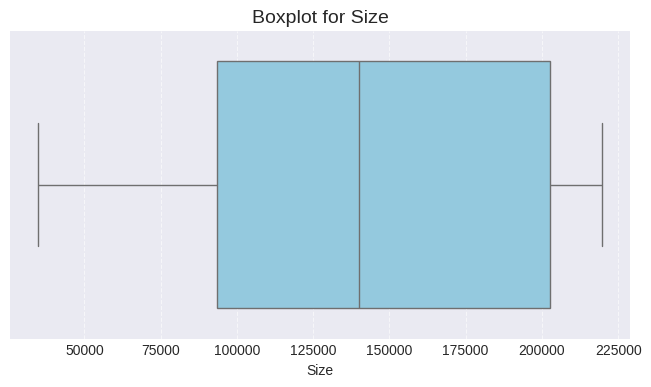

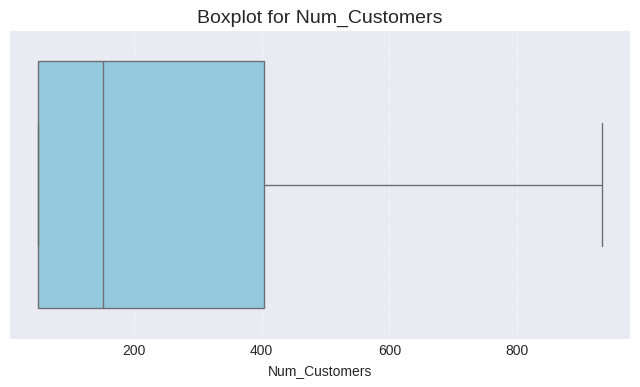

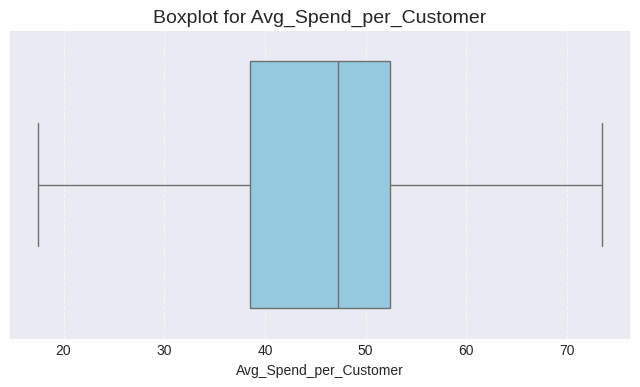

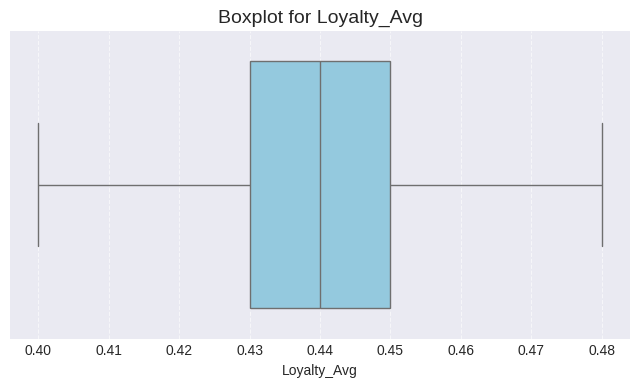

In [32]:
plt.style.use('seaborn-v0_8-darkgrid')

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_full[col], color='skyblue')
    plt.title(f'Boxplot for {col}', fontsize=14)
    plt.xlabel(col)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


In [33]:
print(train_full.isnull().sum())

Store                     0
Dept                      0
Date                      0
Weekly_Sales              0
IsHoliday                 0
Temperature               0
Fuel_Price                0
MarkDown1                 0
MarkDown2                 0
MarkDown3                 0
MarkDown4                 0
MarkDown5                 0
CPI                       0
Unemployment              0
Type                      0
Size                      0
Num_Customers             0
Avg_Spend_per_Customer    0
Loyalty_Avg               0
Month                     0
Fuel_Category             0
HasPromotion              0
dtype: int64


In [34]:
train_full.drop('Month', axis=1, inplace=True)

train_full['Year'] = train_full['Date'].dt.year
train_full['Month'] = train_full['Date'].dt.month
train_full['Week'] = train_full['Date'].dt.isocalendar().week
train_full['Day'] = train_full['Date'].dt.day
train_full['DayOfWeek'] = train_full['Date'].dt.dayofweek

In [35]:
train_full = train_full.sort_values(['Store', 'Dept', 'Date'])
train_full['Sales_Lag_4Weeks'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)

In [36]:
train_full['IsHoliday'] = train_full['IsHoliday'].astype(int)
train_full['HasPromotion'] = train_full['HasPromotion'].astype(int)
train_full['Sales_Lag_4Weeks'] = train_full['Sales_Lag_4Weeks'].fillna(0).astype(int)

train_full.drop('Date', axis=1, inplace=True)

In [37]:
print(train_full.head())

   Store  Dept  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0      1     1      24924.50          0        42.31       2.572        0.0   
1      1     1      46039.49          1        38.51       2.548        0.0   
2      1     1      41595.55          0        39.93       2.514        0.0   
3      1     1      19403.54          0        46.63       2.561        0.0   
4      1     1      21827.90          0        46.50       2.625        0.0   

   MarkDown2  MarkDown3  MarkDown4  ...  Avg_Spend_per_Customer  Loyalty_Avg  \
0        0.0        0.0        0.0  ...                   42.00         0.44   
1        0.0        0.0        0.0  ...                   43.96         0.46   
2        0.0        0.0        0.0  ...                   42.55         0.46   
3        0.0        0.0        0.0  ...                   41.64         0.46   
4        0.0        0.0        0.0  ...                   49.11         0.47   

   Fuel_Category HasPromotion  Year  Month  

In [38]:
train_full = pd.get_dummies(train_full, columns=['Type', 'Fuel_Category'])
train_full = train_full.astype({col: 'int' for col in train_full.select_dtypes('bool').columns})

#train_full.to_csv('FData.csv', index=False)

In [39]:
print(train_full.head())

   Store  Dept  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0      1     1      24924.50          0        42.31       2.572        0.0   
1      1     1      46039.49          1        38.51       2.548        0.0   
2      1     1      41595.55          0        39.93       2.514        0.0   
3      1     1      19403.54          0        46.63       2.561        0.0   
4      1     1      21827.90          0        46.50       2.625        0.0   

   MarkDown2  MarkDown3  MarkDown4  ...  Fuel_Category_(2.47, 2.672]  \
0        0.0        0.0        0.0  ...                            1   
1        0.0        0.0        0.0  ...                            1   
2        0.0        0.0        0.0  ...                            1   
3        0.0        0.0        0.0  ...                            1   
4        0.0        0.0        0.0  ...                            1   

   Fuel_Category_(2.672, 2.871]  Fuel_Category_(2.871, 3.071]  \
0                          

In [40]:
data=train_full

In [41]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,"Fuel_Category_(2.47, 2.672]","Fuel_Category_(2.672, 2.871]","Fuel_Category_(2.871, 3.071]","Fuel_Category_(3.071, 3.27]","Fuel_Category_(3.27, 3.47]","Fuel_Category_(3.47, 3.67]","Fuel_Category_(3.67, 3.869]","Fuel_Category_(3.869, 4.069]","Fuel_Category_(4.069, 4.268]","Fuel_Category_(4.268, 4.468]"
0,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,1,1,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,1,1,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,1,1,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [42]:
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

X = data.drop('Weekly_Sales', axis=1)
y = data['Weekly_Sales']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

split_index = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = (
    X.iloc[:split_index],
    X.iloc[split_index:],
    y.iloc[:split_index],
    y.iloc[split_index:]
)

# Scaling X data
X_train_scale = scaler_X.fit_transform(X_train)
X_test_scale = scaler_X.transform(X_test)

# Scaling y data
y_train_scale = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scale = scaler_y.transform(y_test.values.reshape(-1, 1))

# Transforming data to dataframe and series
X_train_scaled = pd.DataFrame(X_train_scale, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scale,  columns=X_test.columns,  index=X_test.index)

y_train_scaled = pd.Series(y_train_scale.flatten(), index=y_train.index, name='Weekly_Sales')
y_test_scaled = pd.Series(y_test_scale.flatten(), index=y_test.index, name='Weekly_Sales')

# Sampling the train data
sample_idx = y_train_scaled.sample(frac=0.1, random_state=42).index

df_xsample_train = X_train_scaled.loc[sample_idx]
df_ysample_train = y_train_scaled.loc[sample_idx]

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
/usr/local/lib/python3.12/dist-packages/plotly/express/_chart_types.py in scatter(
    data_frame=        Store  Dept  Weekly_Sales  IsHoliday  Te...4               508  

[421570 rows x 26 columns],
    x='Temperature',
    y='Weekly_Sales',
    color=None,
    symbol=None,
    size=None,
    hover_name=None,
    hover_data=None,
    custom_data=None,
    text=None,
    facet_row=None,
    facet_col=None,
    facet_col_wrap=0,
    facet_row_spacing=None,
    facet_col_spacing=None,
    error_x=None,
    error_x_minus=None,
    error_y=None,
    error_y_minus=None,
    animation_frame=None,
    animation_group=None,
    category_orders=None,
    labels=None,
    orientation=None,
    color_discrete_sequence=['#38bdf8'],
    color_discrete_map=None,
    color_continuous_scale=None,
    range_color=None,
    color_continuous_midpoint=None

In [43]:
xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_params = {
    'n_estimators': [200, 500, 800],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}


lgb_model = LGBMRegressor()
lgb_params = {
    'n_estimators': [200, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 1.0]
}


rf_model = RandomForestRegressor()
rf_params = {
    'n_estimators': [200, 500, 800],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


gbr_model = GradientBoostingRegressor()
gbr_params = {
    'n_estimators': [200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5]
}


models = [xgb_model, rf_model, gbr_model, lgb_model]
parameters = [xgb_params, rf_params, gbr_params, lgb_params]
model_names = ['xgb', 'rf', 'gbr', 'lgb']

all_models = []

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [44]:
linear_model=LinearRegression()
linear_model.fit(df_xsample_train, df_ysample_train)
preds=linear_model.predict(X_test_scaled)

# Evaluation
mae = mean_absolute_error(y_test_scaled.values, preds)
rmse = np.sqrt(mean_squared_error(y_test_scaled.values, preds))
r2 = r2_score(y_test_scaled.values, preds)
mape = mean_absolute_percentage_error(y_test_scaled.values, preds)
smape_val = smape(y_test_scaled.values, preds)
accuracy = 100 - smape_val
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE:", mape)
print("SMAPE:", smape_val)
print("Approx Accuracy:", accuracy, "%")

MAE: 0.013571468626419106
RMSE: 0.02217466448251687
R2: 0.9933903571298478
MAPE: 0.05133459137800121
SMAPE: 5.237982888323793
Approx Accuracy: 94.7620171116762 %


In [45]:
# Collect best models, params and metrics then save them to disk
results = []
import os, joblib, json
os.makedirs('best_models', exist_ok=True)

for model, params, name in zip(models, parameters, model_names):
  tscv = TimeSeriesSplit(n_splits=5)
  random = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_iter=10,
    n_jobs=4,
    verbose=2,
    random_state=42
  )

  random.fit(df_xsample_train, df_ysample_train)
  best_model = random.best_estimator_
  best_params = random.best_params_
  all_models.append(best_model)

  # persist the fitted estimator
  model_path = os.path.join('best_models', f'{name}_best_model.joblib')
  joblib.dump(best_model, model_path)

  # predictions and metrics
  preds = best_model.predict(X_test_scaled)
  mae = mean_absolute_error(y_test_scaled.values, preds)
  rmse = np.sqrt(mean_squared_error(y_test_scaled.values, preds))
  r2 = r2_score(y_test_scaled.values, preds)
  mape = mean_absolute_percentage_error(y_test_scaled.values, preds)
  smape_val = smape(y_test_scaled.values, preds)
  accuracy = 100 - smape_val

  print('For', name + ':')
  print("MAE:", mae)
  print("RMSE:", rmse)
  print("R2:", r2)
  print("MAPE:", mape)
  print("SMAPE:", smape_val)
  print("Approx Accuracy:", accuracy, "%")
  print()
  print(best_params)
  print()

  # Append results (convert numerical metrics to native Python types)
  results.append({
    'model_name': name,
    'model_path': model_path,
    'best_params': best_params,
    'mae': float(mae),
    'rmse': float(rmse),
    'r2': float(r2),
    'mape': float(mape),
    'smape': float(smape_val),
    'accuracy': float(accuracy)
  })

# Save summary to disk (JSON) - params may contain numpy types, so use default=str
with open(os.path.join('best_models','best_params_summary.json'),'w') as f:
  json.dump(results, f, default=str, indent=2)

import pandas as pd
metrics_df = pd.DataFrame(results)
print('\nSummary of models:')
print(metrics_df[[ 'model_name','mae','rmse','r2','mape','smape','accuracy']])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
/usr/local/lib/python3.12/dist-packages/plotly/express/_chart_types.py in scatter(
    data_frame=        Store  Dept  Weekly_Sales  IsHoliday  Te...                  0  

[421570 rows x 37 columns],
    x='Temperature',
    y='Weekly_Sales',
    color=None,
    symbol=None,
    size=None,
    hover_name=None,
    hover_data=None,
    custom_data=None,
    text=None,
    facet_row=None,
    facet_col=None,
    facet_col_wrap=0,
    facet_row_spacing=None,
    facet_col_spacing=None,
    error_x=None,
    error_x_minus=None,
    error_y=None,
    error_y_minus=None,
    animation_frame=None,
    animation_group=None,
    category_orders=None,
    labels=None,
    orientation=None,
    color_discrete_sequence=['#38bdf8'],
    color_discrete_map=None,
    color_continuous_scale=N

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



For rf:
MAE: 0.006862863357291395
RMSE: 0.012683096517131794
R2: 0.997837707337894
MAPE: 0.02036077899646446
SMAPE: 2.0348559231457055
Approx Accuracy: 97.9651440768543 %

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
For gbr:
MAE: 0.006668409301556177
RMSE: 0.0122026468009768
R2: 0.9979984245677185
MAPE: 0.020319833378200768
SMAPE: 2.0319090822276897
Approx Accuracy: 97.96809091777232 %

{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 33726, number of used features: 35
[LightGBM] [Info] Start trai

In [46]:
results

[{'model_name': 'xgb',
  'model_path': 'best_models/xgb_best_model.joblib',
  'best_params': {'subsample': 1.0,
   'n_estimators': 800,
   'max_depth': 7,
   'learning_rate': 0.05,
   'colsample_bytree': 1.0},
  'mae': 0.0068903887287306426,
  'rmse': 0.012545426985637698,
  'r2': 0.9978843940777771,
  'mape': 0.021030897500940633,
  'smape': 2.1005577580220804,
  'accuracy': 97.89944224197792},
 {'model_name': 'rf',
  'model_path': 'best_models/rf_best_model.joblib',
  'best_params': {'n_estimators': 500,
   'min_samples_split': 2,
   'min_samples_leaf': 2,
   'max_depth': None},
  'mae': 0.006862863357291395,
  'rmse': 0.012683096517131794,
  'r2': 0.997837707337894,
  'mape': 0.02036077899646446,
  'smape': 2.0348559231457055,
  'accuracy': 97.9651440768543},
 {'model_name': 'gbr',
  'model_path': 'best_models/gbr_best_model.joblib',
  'best_params': {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05},
  'mae': 0.006668409301556177,
  'rmse': 0.0122026468009768,
  'r2': 0.9

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [48]:
train_full.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Store                        421570 non-null  int64  
 1   Dept                         421570 non-null  int64  
 2   Weekly_Sales                 421570 non-null  float64
 3   IsHoliday                    421570 non-null  int64  
 4   Temperature                  421570 non-null  float64
 5   Fuel_Price                   421570 non-null  float64
 6   MarkDown1                    421570 non-null  float64
 7   MarkDown2                    421570 non-null  float64
 8   MarkDown3                    421570 non-null  float64
 9   MarkDown4                    421570 non-null  float64
 10  MarkDown5                    421570 non-null  float64
 11  CPI                          421570 non-null  float64
 12  Unemployment                 421570 non-null  float64
 13 

In [49]:
X = train_full.drop("Weekly_Sales", axis=1)
y = train_full["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
         ("num", MinMaxScaler(), num_cols)

    ],
    remainder='passthrough'
)

lgbm_reg = LGBMRegressor(
    subsample=0.9,
    num_leaves=31,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    colsample_bytree=1.0
)


model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", lgbm_reg)
])


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test.values, y_pred)
print("R2:", r2)


print("Training Completed. Sample Predictions:", y_pred[:5])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3162
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 35
[LightGBM] [Info] Start training from score 13655.762306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



R2: 0.9980238591548908
Training Completed. Sample Predictions: [47465.51006931  3412.50286877 10438.61810805  3433.66025148
  6227.93213229]


In [51]:
# Saving the model for deployment
try:
    print("Saving pipeline!....")
    pipeline_filename = 'gbr_pipeline.pkl'
    joblib.dump(model, pipeline_filename);
    print("Pipeline saved successfully!")

except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")

Saving pipeline!....
Pipeline saved successfully!
